In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataframe
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv', delimiter=',')
#df.head()

In [3]:
# Find percentage of null values
for item in df.columns:
    print(item, df[item].isna().sum())

CAMIS 0
DBA 359
BORO 0
BUILDING 109
STREET 9
ZIPCODE 9
PHONE 5
CUISINE DESCRIPTION 0
INSPECTION DATE 0
ACTION 1135
VIOLATION CODE 6504
VIOLATION DESCRIPTION 6979
CRITICAL FLAG 0
SCORE 23214
GRADE 204505
GRADE DATE 207098
RECORD DATE 0
INSPECTION TYPE 1135


In [4]:
# List the types of restaurants
out_file = 'Cuis_Descr.txt'
cuisine = []
cuisine = df.loc[:,'CUISINE DESCRIPTION'].dropna()
with open(out_file,'w') as file:
    [file.write(item + '\n') for item in cuisine.unique()]

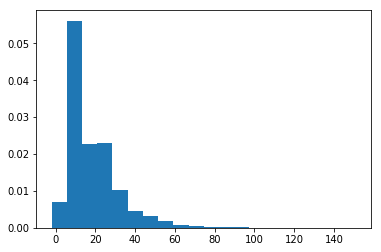

In [5]:
# Plot the distribution of scores
scores = df.loc[:,'SCORE'].dropna()
plt.hist(scores, density=True, bins=20)
plt.show()

In [6]:
scores.describe()

count    376704.000000
mean         18.910181
std          12.958955
min          -2.000000
25%          11.000000
50%          15.000000
75%          24.000000
max         151.000000
Name: SCORE, dtype: float64

In [7]:
# Open the file with the violations
in_file = 'Violations_explanation.csv'
viol_codes = {}
with open(in_file, 'r') as f_in:
    f_in.readline() # Skip the header
    for line in f_in.readlines():
        line = line.strip('\n')
        line = line.split(';')
        viol_codes[line[0]] = line[-1]
        
codes = df['VIOLATION CODE'].map(viol_codes)
df.insert(10, 'VIOLATION TYPE', codes)
#df.head()

<Figure size 432x288 with 0 Axes>

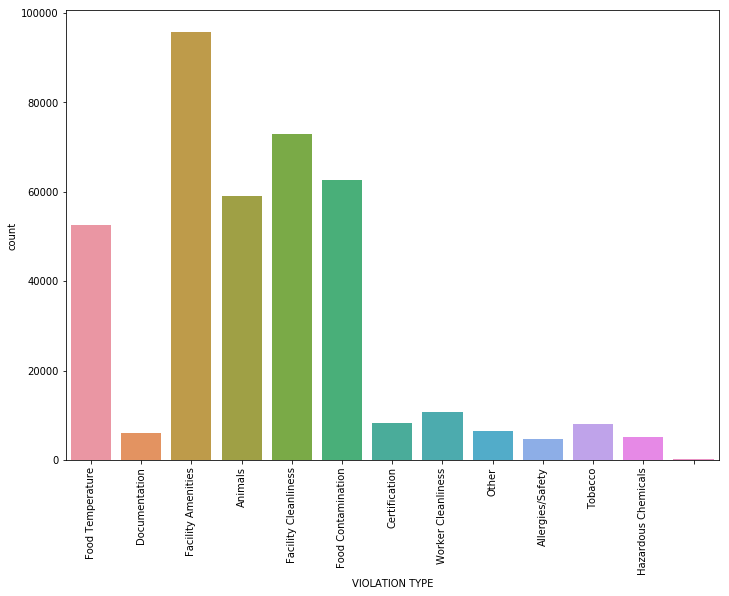

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot the frequencies of violations
fig, ax = plt.subplots(figsize=(11.7, 8.27))
figure = sns.countplot(df['VIOLATION TYPE'], ax=ax)
figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
plt.figure()